# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [81]:
!pip install pycrf
!pip install sklearn-crfsuite
!pip install en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [82]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:


In [83]:
def read_all_sent_or_label(file_name):
    opened = open(file_name, 'r')
    loaded = opened.readlines()
    opened.close()
    
    all_sentence = []
    sentence = ""

    for word in loaded:
        word = word.strip() 
        if word == "":
            all_sentence.append(sentence) 

            sentence = ""
        else:
            if sentence:
                sentence = sentence + " " + word
            else:
                sentence = word
                
    return all_sentence

### Construct the proper sentences from individual words and print the 5 sentences.

In [84]:
train_sent = read_all_sent_or_label('train_sent')
train_label = read_all_sent_or_label('train_label')
test_sent = read_all_sent_or_label('test_sent')
test_label = read_all_sent_or_label('test_label')

In [85]:
def print_sent(sents, label, count=10):
    for i in range(count):
        print("Sentence", i, " : ", sents[i])
        
        display(pd.DataFrame([sents[i].split(), label[i].split()], columns = np.arange(len(sents[i].split())), index = ["sentences", "label"]))


In [86]:
opened = open("train_label", 'r')
loaded = opened.readlines()
opened.close()

/tmp/ipykernel_286409/522755338.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


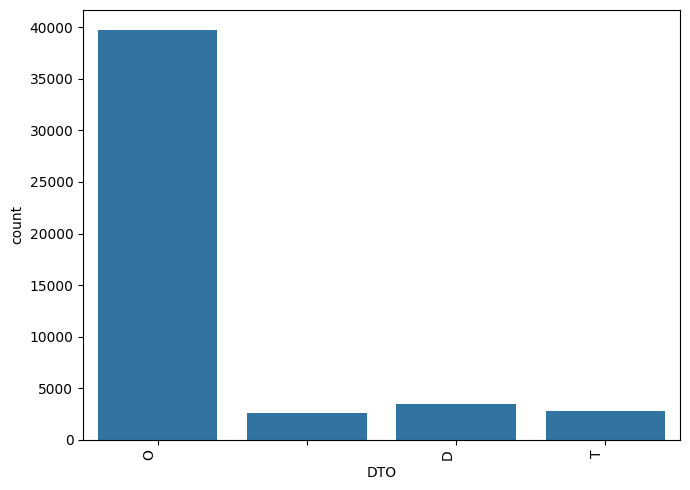

In [87]:
#Words distribution across DTO in train label
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=pd.DataFrame(loaded, columns=["DTO"]), x="DTO", orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [88]:
opened = open("test_label", 'r')
loaded = opened.readlines()
opened.close()

/tmp/ipykernel_286409/653426514.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


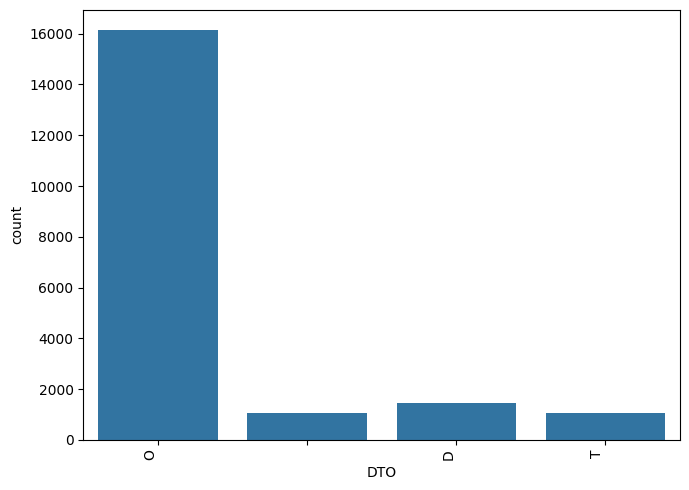

In [89]:
#Words distribution across DTO in test label
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=pd.DataFrame(loaded, columns=["DTO"]), x="DTO", orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Printing first 1 TRAIN sentence and it's labels

In [90]:
print_sent(train_sent, train_label, count=1)

Sentence 0  :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
sentences,All,live,births,>,or,=,23,weeks,at,the,...,",",and,practice,group,(,to,reflect,risk,status,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


### Printing one TEST sentence and it's labels

In [91]:
print_sent(test_sent, test_label, count=1)

Sentence 0  :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
sentences,Furthermore,",",when,all,deliveries,were,analyzed,",",regardless,of,...,2214,;,primary,9.2,%,",",183,of,1994,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


### Count the number of sentences in the processed train and test dataset 

In [92]:
print("No. sentences in processed train dataset is: ", len(train_sent))
print("No. sentences in processed test dataset is: ", len(test_sent))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [93]:
print("No. sentences in processed train dataset is: ", len(train_label))
print("No. sentences in processed test dataset is: ", len(test_label))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

Extracting NOUN or PROPN using tokens

In [94]:
all_noun_propn = []
all_sentence = train_sent + test_sent

for sentence in all_sentence:
    doc = model(sentence)
    
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            all_noun_propn.append(token.text)

In [95]:
len(all_noun_propn)

24373

### Print the top 50 most common tokens with NOUN or PROPN PoS tags

In [96]:
from nltk import FreqDist

In [97]:
word_frequency = FreqDist(all_noun_propn)

In [98]:
pd.DataFrame(word_frequency.most_common(50), columns=["Sentence", "Count"])

,Sentence,Count
0,patients,492
1,treatment,281
2,%,247
3,cancer,200
4,therapy,175
5,study,153
6,disease,141
7,cell,140
8,lung,116
9,group,94


## Model1: 
#### Using the same code from CRF.ipynb (Custom NER: Python Implementation Part-I)


## Defining features for CRF
*******
list of features used:
- f1 = serves as word id
- f2 = last three characters
- f3 = last two characters
- f4 = is the word in all uppercase
- f5 = is the word a number
- f6 = is the word starting with a capital lettes

extra feature:
if pos>0:
- fx1 = prev_word to lower
- fx2 = prev_word is upper
- fx3 = prev_word is digits
- fx4 = prev_word starts with capital letter

else:
- fx1 = BEG(beginning of text)

if pos reached end:
- fx1 = ENd(ending of text)

In [99]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

### Write a code/function to get the features for a sentence

In [100]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Visualizing the input features

In [101]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False']

In [102]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [103]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [104]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [105]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

## Build the CRF Model

In [106]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [107]:
repr(crf)

'CRF(max_iterations=100)'

### Tranning model

In [108]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [109]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [110]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9044158773940202


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

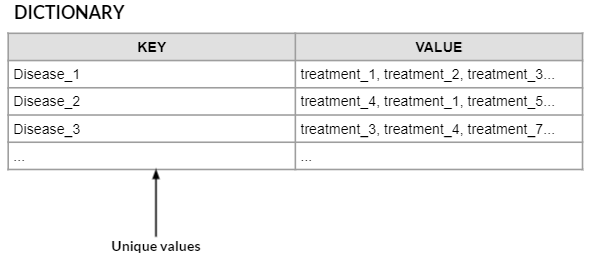

## Creating Dataframe for Disease	and Treatments

In [111]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [112]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,cellulitis,G-CSF therapy intravenous antibiotic treatment
...,...,...
101,temporomandibular joint arthropathy,arthroscopic treatment
102,severe secondary peritonitis,Surgical management
103,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
104,Poliomyelitis prevention,live oral poliovirus vaccines


### Predict the treatment for the some diseases

In [113]:
disease = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == disease), ["Disease", "Treatments"]]


,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


In [114]:
disease = 'coronary-artery disease'
D_n_T_DF.loc[(D_n_T_DF.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
2,coronary-artery disease,Antichlamydial antibiotics


In [115]:

disease = 'primary pulmonary hypertension ( PPH )'
D_n_T_DF.loc[(D_n_T_DF.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
3,primary pulmonary hypertension ( PPH ),fenfluramines


## Model2: Adding POS tag in feature

In [116]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos] # adding POS tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1] # adding POS tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [117]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

In [118]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ']

In [119]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'BEG']

In [120]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [121]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [122]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [123]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [124]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [125]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [126]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9073283958612477


## Creating Dataframe for Disease	and Treatments

In [127]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [128]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
106,temporomandibular joint arthropathy,arthroscopic treatment
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,chronic renal failure,Epoetin


### Predict the treatment for some of diseases

In [129]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


In [130]:
disease = 'coronary-artery disease'
D_n_T_DF.loc[(D_n_T_DF.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
3,coronary-artery disease,Antichlamydial antibiotics


### we can see some improvement in accuracy from 90.4 to 90.7 percentage

- lets try adding Depency tag and see result

## Model3: Adding POS tag and Dependancy tag in feature

In [131]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [132]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [133]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [134]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [135]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [136]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [137]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [138]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [139]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [140]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [141]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9050879539751051


## Creating Dataframe for Disease	and Treatments

In [142]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [143]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"aspirin , 3 mg warfarin with 80 mg aspirin , o..."
2,unstable angina,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,essential hypertension,moxonidine
...,...,...
97,temporomandibular joint arthropathy,arthroscopic treatment
98,severe secondary peritonitis,Surgical management
99,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
100,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [144]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


### we can see some improvement in accuracy from 90.595 to 90.693

- lets try increasing max_iterations to 500

## Model 4: max_iterations to 500

In [145]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [146]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [147]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [148]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [149]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [150]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [151]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [152]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=500)

In [153]:
crf.fit(X_train, y_train)

CRF(max_iterations=500)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [154]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [155]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9127700864467786


## Creating Dataframe for Disease	and Treatments

In [156]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [157]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,cancer hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,essential hypertension,moxonidine
...,...,...
106,temporomandibular joint arthropathy,arthroscopic treatment
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [158]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments


## We can see some improvement in accuracy from 90.5% to 91.27%
- And we can see there is an increase in the number of record of disease and treatement from 108 to 111.
